In [4]:
import os
import sys

import numpy as np
import math
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo as mc
import chirality_tools as chir
from numba import jit
from numba_progress import ProgressBar


ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [5]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Initialization

In [6]:
N = 20
a = params["lattice_constant"]

file_path = f'../data/q2_degeneracy/s{N}.csv'
trj_final = pd.read_csv(file_path, index_col=['realization','frame','id'])
# be careful with the realization number...
realization = 1
trj = trj_final.loc[idx[realization,:,:]]

# Visualization

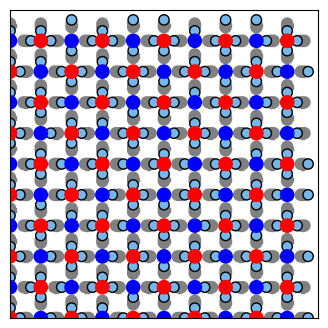

In [6]:
fig, ax= plt.subplots(figsize=(4,4))

region_limit = N*params['lattice_constant'].magnitude
ice.draw_frame(trj, frame_no=0,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

mc.display_vertices(trj,N,a,ax)
#mc.display_arrows(trj,N,a,ax)
#mc.display_lines(trj,N,a,ax)

plt.show()

# Magnetic Structure Factor for Spins


In [7]:
def reciprocal_space(N,a):
    kx = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(N,d=a) )
    ky = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(N,d=a) ) 

    KX, KY = np.meshgrid(kx,ky)
    N = len(kx)
    reciprocal_space = np.zeros((N,N,2))
    reciprocal_space[:,:,0] = KX
    reciprocal_space[:,:,1] = KY

    return reciprocal_space

def reciprocal_space_free(N,a):
    amount_bz = 3
    klim = np.pi/a*amount_bz
    kx = np.linspace(-klim,klim,120)
    ky = np.linspace(-klim,klim,120)

    KX, KY = np.meshgrid(kx,ky)
    N = len(kx)
    reciprocal_space = np.zeros((N,N,2))
    reciprocal_space[:,:,0] = KX
    reciprocal_space[:,:,1] = KY

    return reciprocal_space


In [8]:
%%time
from itertools import combinations

# pre loading shit
centers, dirs, rels = mc.trj2numpy(trj)
reciprocal_lattice = reciprocal_space_free(N,a.magnitude)
rs_indices = np.array(np.meshgrid(
    np.arange(reciprocal_lattice.shape[0]),
    np.arange(reciprocal_lattice.shape[0])
    )).T.reshape(-1,2)
# pairs = np.asarray(list(combinations(np.arange(len(centers)),2)) + [(i,i) for i in range(len(centers))] )

CPU times: user 0 ns, sys: 4.56 ms, total: 4.56 ms
Wall time: 2.79 ms


In [7]:
msf = pd.read_csv(f'../data/q2_degeneracy/msf{N}.csv',header=None,index_col=None).to_numpy()
msf = np.complex128(msf)

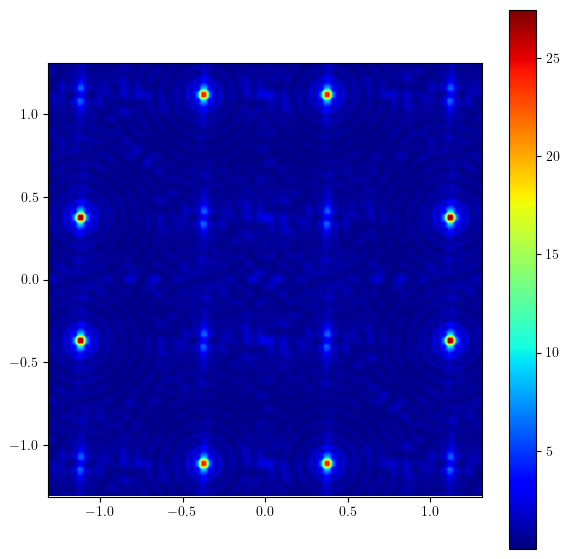

In [8]:
kedge = 3.5 * np.pi / a.magnitude
fig, ax = plt.subplots(figsize=(7,7))
image = ax.imshow(np.abs(msf),interpolation='bilinear', cmap='jet' ,origin='lower',extent=[-kedge,kedge,-kedge,kedge])
fig.colorbar(image)

plt.show()

## Charge correlations

This is the FFT way of computing it

In [21]:
# premade topology
centers, dirs, rels = mc.trj2numpy(trj)
vrt_lattice = mc.create_lattice(a.magnitude,N,spos=(0,0))
indices_matrix = mc.indices_lattice(vrt_lattice,centers, a.magnitude, N)

# lattice with the topological charges
q = mc.get_charge_lattice(indices_matrix,dirs)

In [22]:
q.shape

(10, 10)

In [23]:
np.sum(np.abs(q) == 4) / N**2

0.0

In [24]:
def flatten_structures(vertices,indices,charge):

    rows,cols = vertices.shape[:2]

    fv = np.array([vertices[i,j,:] for i in range(rows) for j in range(cols)])
    fi = np.array([indices[i,j,:] for i in range(rows) for j in range(cols)])
    fq = np.array([charge[i,j] for i in range(rows) for j in range(cols)])
    
    return fv, fi, fq


In [25]:
# i tested, and believe these are correctly flattened
fvertices = vrt_lattice.reshape(N**2,3)
findices = indices_matrix.reshape(N**2,4)
fcharge = q.reshape(-1)

# testing
# fvertices - fv

In [26]:
def quick_transform(corr_data):
    corr_data[:,0] = corr_data[:,0] / np.max(corr_data[:,0])
    corr_data[:,[1,2]] = np.abs(corr_data[:,[1,2]])
    df = pd.DataFrame(corr_data,columns=['corr','dax','day'])
    return df


In [27]:
preloaded_pairs = np.array([ [i,j] for i in range(N**2) for j in range(i,N**2) ])
corr_data = mc.charge_correlations(fcharge,fvertices,preloaded_pairs, N, a.magnitude)
corr = quick_transform(corr_data).round(5)

In [28]:
max_csize = int(N/2 + 1)

In [29]:
av_corr = np.zeros((max_csize,max_csize))

for dax,dfax in corr.groupby('dax'):
    for day,dfaxy in dfax.groupby('day'):
        av_corr[int(dax), int(day)] = dfaxy['corr'].mean()

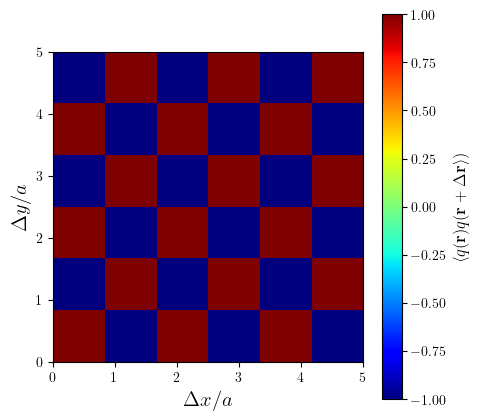

In [30]:
edge = N/2
fig, ax = plt.subplots(figsize=(5,5))
image = ax.imshow(av_corr, cmap='jet' ,origin='lower',extent=[0,edge,0,edge])
ax.set_xlabel(r"$\Delta x /a$", fontsize=15)
ax.set_ylabel(r"$\Delta y /a$", fontsize=15)
cbar = fig.colorbar(image)
cbar.set_label(label=r'$\langle q(\mathbf{r})q(\mathbf{r} + \Delta \mathbf{r} \rangle)$', size='large')

plt.show()

In [31]:
kx = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(max_csize,d=1) )
ky = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(max_csize,d=1) )
fft = np.fft.fftshift(np.fft.fft2(av_corr))

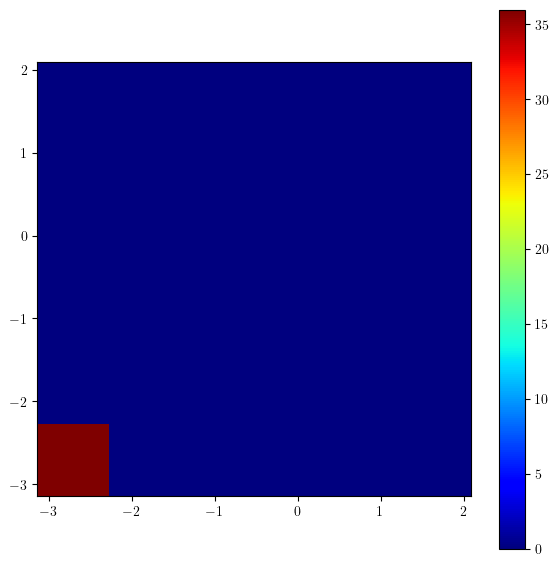

In [32]:
fig, ax = plt.subplots(figsize=(7,7))
image = ax.imshow(np.abs(fft), cmap='jet' ,origin='lower',extent=[min(kx),max(ky),min(kx),max(ky)])
fig.colorbar(image)

plt.show()